(Example from the Book p.29 ff)

A lighthouse is somewhere off a piece of straight coastline at a position $\alpha$ (alpha) along the shore and a distance <br>
$\beta$ (beta) out at sea. It emits a series of short highly collimated flashes at random intervals and hence at random azimuths, $\theta$. <br>
These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not <br>
the angle from which it came. <br>
N flashes have so far been recorded at positions $\{x_k\}$. Where is the lighthouse?’

<img src="pictures01/lightHouseGeometry.jpg">

If we assume a uniform distribution, $ prob(\theta | \{x_k\}, \alpha, \beta, I) = \frac{1}{\pi}$ for $\theta$ between $[- \pi/2 , + \pi/2]$, we get a Cauchy-Distribution for the $x_k$ :

$$
prob(x_k | \alpha, \beta, I) = \frac{\beta}{\pi [\beta^2 + (x_k - \alpha)^2]}
$$

Using Bayes' theorem and assuming independence of the measurements, the log-prob function L is given by:

$$
  L = log(prob(  \alpha, \beta | \{x_k\} , I) = const + \sum^N_{k=1}{(log(\beta) - log(\beta^2 + (x_k - \alpha)^2))}
$$

Our best estimate for $\alpha$ and $\beta$ are the values that maximize the log-prob function L.
We can take the partial derivatives of L for $\alpha$ and $\beta$ and set them equal to zero and solve the equations numerically. Or we use gradient descent to find the minimum of -L, i.e. the maximum of L.
Thus we end up with a non-liniear optimization problem / non-linear root finding problem that we will have to solve numerically:

$$
\frac{\partial L}{\partial \alpha} = \sum^N_{k=1}{\frac{2 (x_k - \alpha)}{\beta^2 + (x_k - \alpha)^2}} = 0 \\


\frac{\partial L}{\partial \beta} = \frac{N}{\beta} - \sum^N_{k=1}{\frac{2 \beta}{\beta^2 + (x_k - \alpha)^2}} = 0
$$

In [6]:
# define a function that generates the data we want to use:

import numpy as np

a = 1       # on shore position of Lighthouse
b = 2       # off shore position of Lighthouse
N = 10      # number of datapoints /measurements to generate

def generate_x_ks(a, b, N=10):
    thetas = np.random.uniform(low= - np.pi * 0.5, high= np.pi * 0.5, size=(1,N))
    x_ks = a + b * np.tan(thetas)
    return x_ks

# test:
#generate_x_ks(a, b, N)

In [7]:
# define a function that gives back the partial derivative of L after a(lpha) as a function of a and b(eta):

def grad_L_a(x_ks):
    def grad(a, b):
        diffs = x_ks - a
        numerator = diffs
        denominator = b**2 + diffs**2
        fractions = numerator/denominator
        return 2 * np.sum(fractions)  
    return grad

# test:
""" a = 1
b = 2
x_ks = generate_x_ks(a,b)

dLa = grad_L_a(x_ks)
dLa(5, b) """

' a = 1\nb = 2\nx_ks = generate_x_ks(a,b)\n\ndLa = grad_L_a(x_ks)\ndLa(5, b) '

In [8]:
# define a function that gives back the partial derivative of L after b as a function of a and b:
def grad_L_b(x_ks):
    def grad(a, b):
        N = np.size(x_ks)
        diffs = x_ks - a
        numerator = b
        denominator = b**2 + diffs**2
        fractions = numerator/denominator
        return (N/b) - 2 * np.sum(fractions)  
    return grad

# test:
""" a = 1
b = 2
x_ks = generate_x_ks(a,b)
dLb = grad_L_b(x_ks)
dLb(a, b) """

' a = 1\nb = 2\nx_ks = generate_x_ks(a,b)\ndLb = grad_L_b(x_ks)\ndLb(a, b) '

In [9]:
# implement gradient descent to find the maximum of L, i.e. the minimum of -L:

def gradient_descent(x, y, x_ks, learning_rate=0.01, N_iterations=1000):
    # We are looking for a maximum of L - maybe this function should be called "gradient-ascent"
    # y is the strarting-point for the off-shore distance - hence allways positive:
    if y < 0 or y==0:
        return
    dL_da = grad_L_a(x_ks)
    dL_db = grad_L_b(x_ks)
    for _ in np.arange(N_iterations):
        x_old = x
        x = x + learning_rate * dL_da(x, y) # plus learningrate * ... is correct in this case, because we find the minimum of -L
        y = y + learning_rate * dL_db(x_old, y)
    return x,y

# test:
a = 2       # on shore position of Lighthouse
b = 7       # off shore position of Lighthouse
N = 400      # number of datapoints /measurements to generate

x_ks = generate_x_ks(a, b, N)
# starting points for gradient descent:
start_a = 3
start_b = 22
gradient_descent(start_a, start_b, x_ks)

(2.144279575640155, 7.910325487350291)

### Additonal things to do:
- plot graphs of $prob(\alpha | \{x_k\}, I)$ and $prob(\beta | \{x_k\}, I)$
- calculate error-bars for $\alpha$ and $\beta$ and the correlation-matrix
- add (Gaussian) noise to the problem - either in $\theta$ or in $x_k$
- solve the problem by calculating the zeros of the partial derivatives (i.e. a different algorithm)
- plot a sequence of graphs showing the successive approximation of the estimated location and the real location of the light-house. Add 90% prob-contours to the plot
- make the sequence of plots an animation

We want to plot the distributions of $\alpha$ and $\beta$. To that end we try to calculate the marginal distribution $prob(\alpha|\{x_k\},I)$ by calculating the integral over $\beta$ of $prob(  \alpha, \beta | \{x_k\} , I)$ by summation. <br>
Using Bayes as usual we calculate with <br>
$$
prob(x_k | \alpha, \beta, I) = \frac{\beta}{\pi [\beta^2 + (x_k - \alpha)^2]}
$$ 
instead of
$$
prob(  \alpha, \beta | \{x_k\} , I)
$$
The list prob_a is the list of the values of the marginal distribution evaluated on the points of alpha_range. <br>
<br>
There is a problem though, as one can see, when executing the code in the next cells: the product of the probabilities $prob(x_k| \alpha,\beta,I)$ becomes very small the more datapoints $x_k$, we have, since all these probabilities are smaller then one. That's why I tried to sum over the logs of those probabilites - which does not help either... <br>
So I am in need of some scaling here. Ironically I by dropping the normalization of the distributions, I dropped the scaling...<br>
On the other handside - I just want to plot the graphs, I do not need the exact probabilities. (The scaling finally applied is dividing by the max)

Using Bayes' theorem and assuming independence of the measurements, the log-prob function L is given by:

$$
  L = log(prob(  \alpha, \beta | \{x_k\} , I) = const + \sum^N_{k=1}{(log(\beta) - log(\beta^2 + (x_k - \alpha)^2))}
$$

In [10]:
 # The log-prob of X_k given alpha, beta and I up to a constant 

def log_prob_Xk_g_a_b_I(x_ks):
    # returns a function log-prob(alpha,beta)
    # which is the log of the prob of X_k given alpha, beta, I up to a constant 
    # - as a function of alpha and beta

    def log_prob(alpha, beta):
        N = x_ks.shape[0]
        diffs = x_ks - alpha
        return N * np.log(beta) - np.sum(np.log(beta**2 + diffs**2))

    return log_prob

# test:
""" x_ks = np.array([1,2,3])
log_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)
a = 1
b = np.e
log_prob(a,b) """



' x_ks = np.array([1,2,3])\nlog_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)\na = 1\nb = np.e\nlog_prob(a,b) '

In [11]:
# try to calculate the marginal distribution prob(a|{x_k},I) - calculating the integral over b of prob(a,b|{x_k}, I) by sums
# prob_a is the list of the values of the marginal distribution of a evaluated on the points of alpha_range.
#
# There is a problem though: the product of the probabilities prob({x_k}| a,b,I) becomes very small the more datapoints, x_k, we have...

alpha_range = np.linspace(-10, 10, num=1000, retstep=True)
beta_range = np.linspace(0, 10, num=50, retstep=True) # returns (samples, spacing between samples)

# integration by summation:

# just for testing this cell:
a = 2
b = 7
N = 100
x_ks = generate_x_ks(a, b, N)

log_prob = log_prob_Xk_g_a_b_I(x_ks=x_ks)

prob_a = []
db = beta_range[1]
for alpha in alpha_range[0]:
    prob_beta = 0.0
    for beta in beta_range[0] + 0.01: # add 0.01, because beta must not be zero
        prob_beta = prob_beta + np.exp(log_prob(alpha,beta)) * db
    
    #print(f"probs:{prob_beta}")
    prob_a.append(prob_beta)

# this is the max-scaling:
max_prob_a = max(prob_a)
scaled_probs_a = np.array(prob_a)/max_prob_a

# test:
#scaled_probs_a

# in the analogous way try to calculate the marginal distribution prob(b|{x_k},I) - calculating the integral over a of prob(a,b|{x_k}, I) by sums
# prob_b is the list of the values of the marginal distribution of b evaluated on the points of beta_range.

prob_b = []
da = alpha_range[1]
for beta in beta_range[0] + 0.01: # add 0.01, because beta must not be zero
    prob_alpha = 0.0
    for alpha in alpha_range[0]:
        prob_alpha = prob_alpha + np.exp(log_prob(alpha,beta)) * da
    
    #print(f"prob_alpha:{prob_alpha}")
    prob_b.append(prob_alpha)

# this is the max-scaling:
max_prob_b = max(prob_b) 
scaled_probs_b = np.array(prob_b)/max_prob_b

print(f"a, b: {a, b}")


a, b: (2, 7)


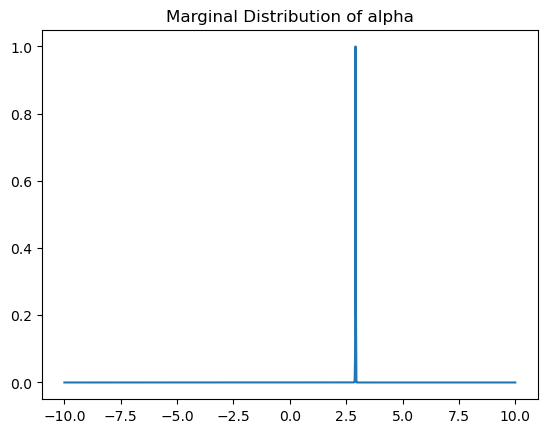

In [12]:
import matplotlib.pyplot as plt

plt.title("Marginal Distribution of alpha")
plt.plot(alpha_range[0], scaled_probs_a)
plt.show()


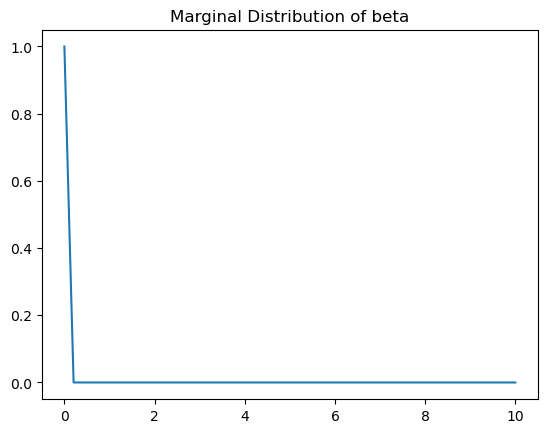

In [13]:
plt.title("Marginal Distribution of beta")
plt.plot(beta_range[0], scaled_probs_b)
plt.show()

#### It looks as if numerical integration has some tripwires ...

# Calculate the marginal distributions with the scipy.integrate library

In [14]:
import scipy.integrate as integrate
from scipy.integrate import quad
from warnings import catch_warnings, warn

def log_prob_cauchy(alpha, beta, x_k):
    # returns the log-prob(alpha,beta, x_k))
    diff = x_k - alpha
    result = np.log(beta) - np.log(beta**2 + diff**2)
    return result

def marginal_alpha(x_ks):
    # we are going to use scipy.quad - which is integrating over the first argument, .e. here : alpha
    def integrand(alpha, beta):
        log_prob_sum = np.sum([log_prob_cauchy(alpha, beta, x_k) for x_k in x_ks])
        return np.exp(log_prob_sum)
    return integrand

def marginal_beta(x_ks):
    # we are going to use scipy.quad - which is integrating over the first argument, i.e. here: beta
    def integrand(beta, alpha):
        log_prob_sum = np.sum([log_prob_cauchy(alpha, beta, x_k) for x_k in x_ks])
        return np.exp(log_prob_sum)
    return integrand

integrand_marginal_alpha = marginal_alpha(x_ks)
integrand_marginal_beta = marginal_beta(x_ks)

marginal_alpha = [quad(integrand_marginal_alpha, -10, 10, args=(beta))[0] for beta in beta_range[0]]
marginal_beta = [quad(integrand_marginal_beta, 0.5, 5, args=(alpha))[0] for alpha in alpha_range[0]]

marginal_over_alpha = np.array(marginal_alpha)
max_alpha = np.max(marginal_over_alpha)
scaled_marginal_over_alpha = marginal_over_alpha = np.array(marginal_alpha)/max_alpha

marginal_over_beta = np.array(marginal_beta)
max_beta = np.max(marginal_over_beta)
scaled_marginal_over_beta = marginal_over_beta = np.array(marginal_beta)/max_beta



C:\Users\Hal9\AppData\Local\Temp\ipykernel_13220\135270561.py:8: RuntimeWarning: divide by zero encountered in log
  result = np.log(beta) - np.log(beta**2 + diff**2)


In [15]:
print(f"alpha:{a}")
print(f"beta:{b}")

alpha:2
beta:7


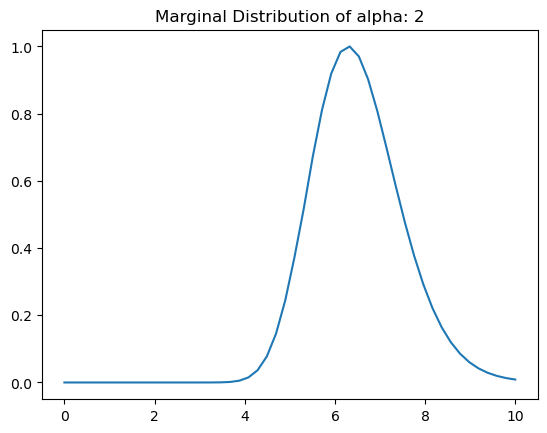

In [16]:
plt.title(f"Marginal Distribution of alpha: {a}")
plt.plot(beta_range[0], scaled_marginal_over_alpha)
plt.show()

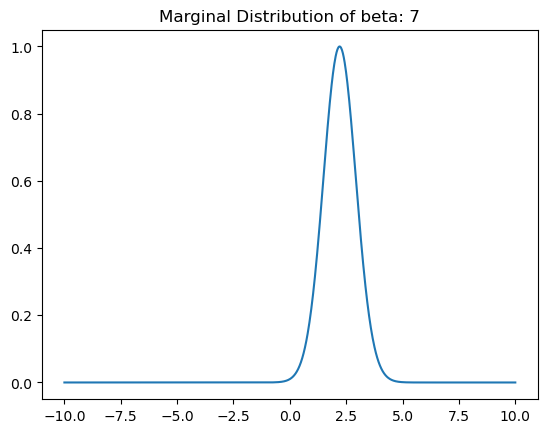

In [17]:
plt.title(f"Marginal Distribution of beta: {b}")
plt.plot(alpha_range[0], scaled_marginal_over_beta)
plt.show()

## Plot Contours of the Posterior

In [84]:

def log_prob_cauchy_from_data(x_ks):
    # we are going to use scipy.quad - which is integrating over the first argument, .e. here : alpha
    def log_prob(alpha, beta):
        result = np.zeros([beta.shape[0], alpha.shape[1]])
        for index_a, a in np.ndenumerate(alpha):
            for index_b, b in np.ndenumerate(beta):
                result[index_b[0],index_a[1]] = np.sum([np.log(b) - np.log(b**2 + (x_ks - a)**2) for x_k in x_ks])
        return np.exp(result)
    return log_prob

A:(50, 100)
B:(50, 100)
Z.shape:(50, 100)


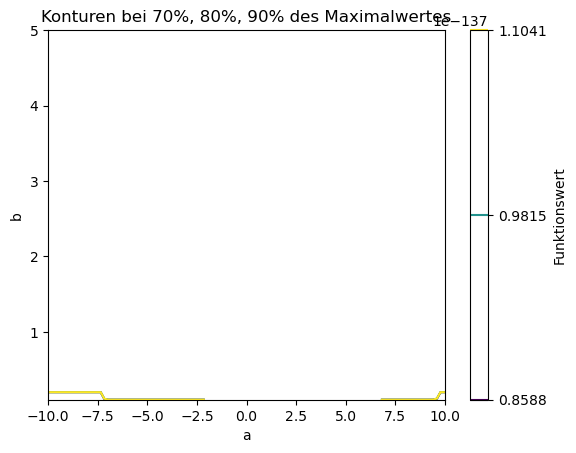

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Beispiel einer Funktion f(x, y)
# just for testing this cell:
a = 2
b = 4
N = 400
x_ks = generate_x_ks(a, b, N)
log_prob_cauchy_integrand = log_prob_cauchy_from_data(x_ks)
 
# Erstelle Gitterpunkte für x und y
a_s = np.linspace(-5, 5, 100)
b_s = np.linspace(0.1, 7, 50)
A, B = np.meshgrid(a_s, b_s)
print(f"A:{A.shape}")
print(f"B:{B.shape}")

# # Berechne die Funktionswerte
Z = np.zeros([B.shape[0], A.shape[1]])
print(f"Z.shape:{Z.shape}")
Z = log_prob_cauchy_integrand(A, B)
z_max = np.max(Z)
Z = Z/z_max
#print(f"Z:{Z}")

# Bestimme die Werte, bei denen die Konturen gezeichnet werden sollen (70%, 80%, 90% des Maximalwertes)
#levels = [0.7 * z_max, 0.8 * z_max, 0.9 * z_max]
levels = [0.9 * z_max]

# Erstelle eine Konturplot
plt.contour(A, B, Z, levels=levels)
plt.colorbar(label='Funktionswert')

# Zeige das Plot
plt.title('Konturen bei 70%, 80%, 90% des Maximalwertes')
plt.xlabel('a')
plt.ylabel('b')
plt.show()



In [83]:
Q = np.array([[-728.48513931, -629.69764697, -696.96489252],
 [-480.1716572,  -389.19437294, -448.15923346],
 [-427.33301238, -346.61426661, -396.48689821],
 [-400.55883816, -329.47327549, -372.00879705],
 [-384.64955442, -322.03191413, -358.64233093]])
np.exp(Q)

array([[4.19685397e-317, 3.35572724e-274, 2.05112958e-303],
       [2.91138012e-209, 9.44129232e-170, 2.32765116e-195],
       [2.58006584e-186, 2.93316614e-151, 6.42581119e-173],
       [1.09523398e-174, 8.15782754e-144, 2.74556811e-162],
       [8.88834798e-168, 1.39096658e-140, 1.75232517e-156]])

X.size:(100, 10)
Y:(100, 10)
Z:(100, 10)


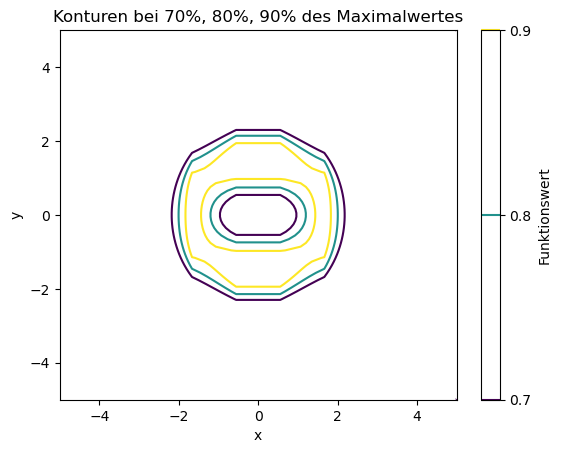

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Beispiel einer Funktion f(x, y)
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

# Erstelle Gitterpunkte für x und y
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
print(f"X.size:{X.shape}")
print(f"Y:{Y.shape}")
# Berechne die Funktionswerte
Z = f(X, Y)
print(f"Z:{Z.shape}")

# Bestimme den Maximalwert der Funktion
z_max = np.max(Z)

# Bestimme die Werte, bei denen die Konturen gezeichnet werden sollen (70%, 80%, 90% des Maximalwertes)
levels = [0.7 * z_max, 0.8 * z_max, 0.9 * z_max]

# Erstelle eine Konturplot
plt.contour(X, Y, Z, levels=levels)
plt.colorbar(label='Funktionswert')

# Zeige das Plot
plt.title('Konturen bei 70%, 80%, 90% des Maximalwertes')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [27]:
f([8,3],[9,2])

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'